In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states of each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, (h0, c0))
    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:,-1,:])
    return out

In [7]:
# Instantiate the model
model = RNN(n_inputs=28, n_hidden=128, n_rnnlayers=2, n_outputs=10)
model.to(device)

RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
# Train the model
n_epochs = 10

# stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 28, 28)

    # zer0 the parameter gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # Get train loss and test loss
  train_loss = np.mean(train_loss) # a little misleading

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/10, Train Loss: 0.5229, Test Loss: 0.1356
Epoch 2/10, Train Loss: 0.1322, Test Loss: 0.0917
Epoch 3/10, Train Loss: 0.0831, Test Loss: 0.0689
Epoch 4/10, Train Loss: 0.0623, Test Loss: 0.0766
Epoch 5/10, Train Loss: 0.0513, Test Loss: 0.0641
Epoch 6/10, Train Loss: 0.0410, Test Loss: 0.0493
Epoch 7/10, Train Loss: 0.0385, Test Loss: 0.0429
Epoch 8/10, Train Loss: 0.0343, Test Loss: 0.0486
Epoch 9/10, Train Loss: 0.0291, Test Loss: 0.0390
Epoch 10/10, Train Loss: 0.0252, Test Loss: 0.0399


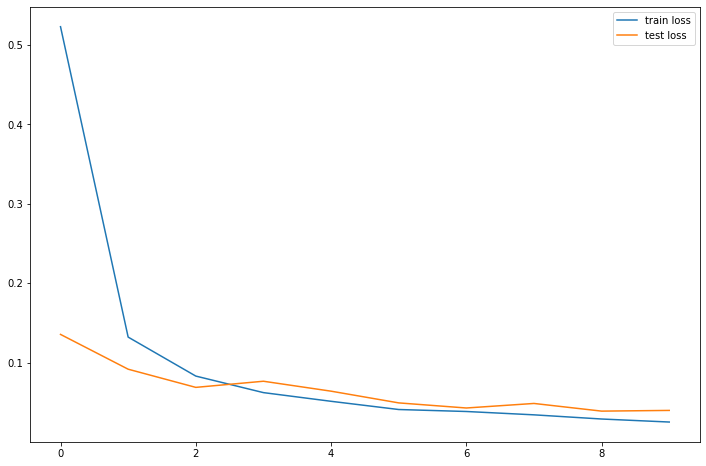

In [11]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,8))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [12]:
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # reshape the input
  inputs = inputs.view(-1, 28, 28)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # reshape the input
  inputs = inputs.view(-1, 28, 28)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9933, Test acc: 0.9881


In [13]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(f"{cm}\n")
  plt.figure(figsize=(12,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 976    0    0    0    0    0    3    1    0    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   2    4 1020    0    0    0    1    3    2    0]
 [   0    0    1 1003    0    2    0    1    3    0]
 [   0    1    0    0  974    0    2    2    0    3]
 [   1    1    0    5    0  883    2    0    0    0]
 [   3    2    0    0    2    3  948    0    0    0]
 [   1   13    5    0    0    0    0 1005    0    4]
 [   3    5    2    0    1    4    2    0  954    3]
 [   1    0    0    3   11    1    0    3    5  985]]



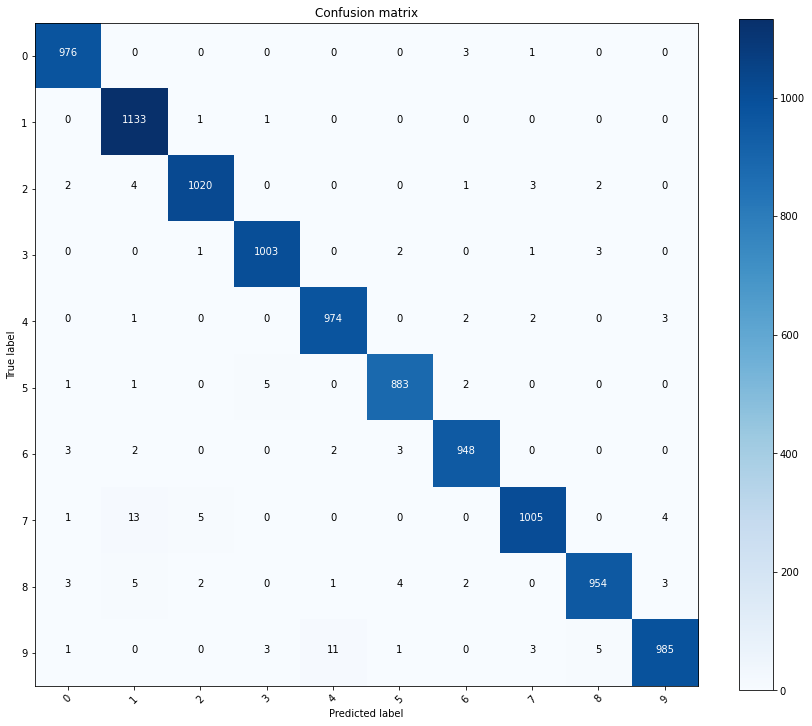

In [15]:
# Get all predictions in an array and plot confusiuon matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)
  # reshape the input
  inputs = inputs.view(-1, 28, 28)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,list(range(10)))